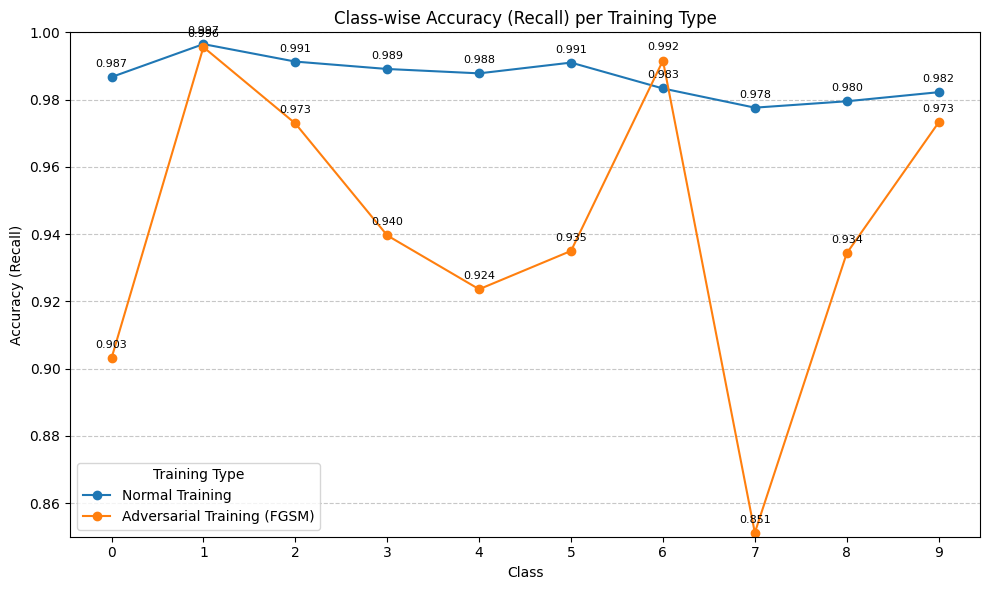

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_classwise_accuracy(csv_path, scenario_map):
    """
    csv_path: path to CSV
    scenario_map: dict of {label: exact scenario name}
    """
    df = pd.read_csv(csv_path)
    df.set_index(['Scenario', 'Class'], inplace=True)
    df.index = df.index.set_levels(df.index.levels[0].astype(str), level=0)

    plt.figure(figsize=(10, 6))

    all_accuracies = {}

    for label, scenario in scenario_map.items():
        if scenario not in df.index.levels[0]:
            print(f"Scenario '{scenario}' not found.")
            continue

        # Extract recall
        acc = df.loc[scenario, 'recall']
        acc.index = acc.index.astype(int)
        acc = acc.sort_index()

        all_accuracies[label] = acc

        # Plot with labels
        plt.plot(acc.index, acc.values, marker='o', label=label)
        for x, y in zip(acc.index, acc.values):
            plt.text(x, y + 0.003, f"{y:.3f}", ha='center', fontsize=8)

    plt.title("Class-wise Accuracy (Recall) per Training Type")
    plt.xlabel("Class")
    plt.ylabel("Accuracy (Recall)")
    plt.ylim(0.85, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(range(10))
    plt.legend(title="Training Type")
    plt.tight_layout()
    plt.show()

    return all_accuracies

accuracies = plot_classwise_accuracy(
    "Classification_Report_Comparison.csv",
    scenario_map={
        "Normal Training": "Clean",
        "Adversarial Training (FGSM)": "AdvTrain_Clean"
    }
)

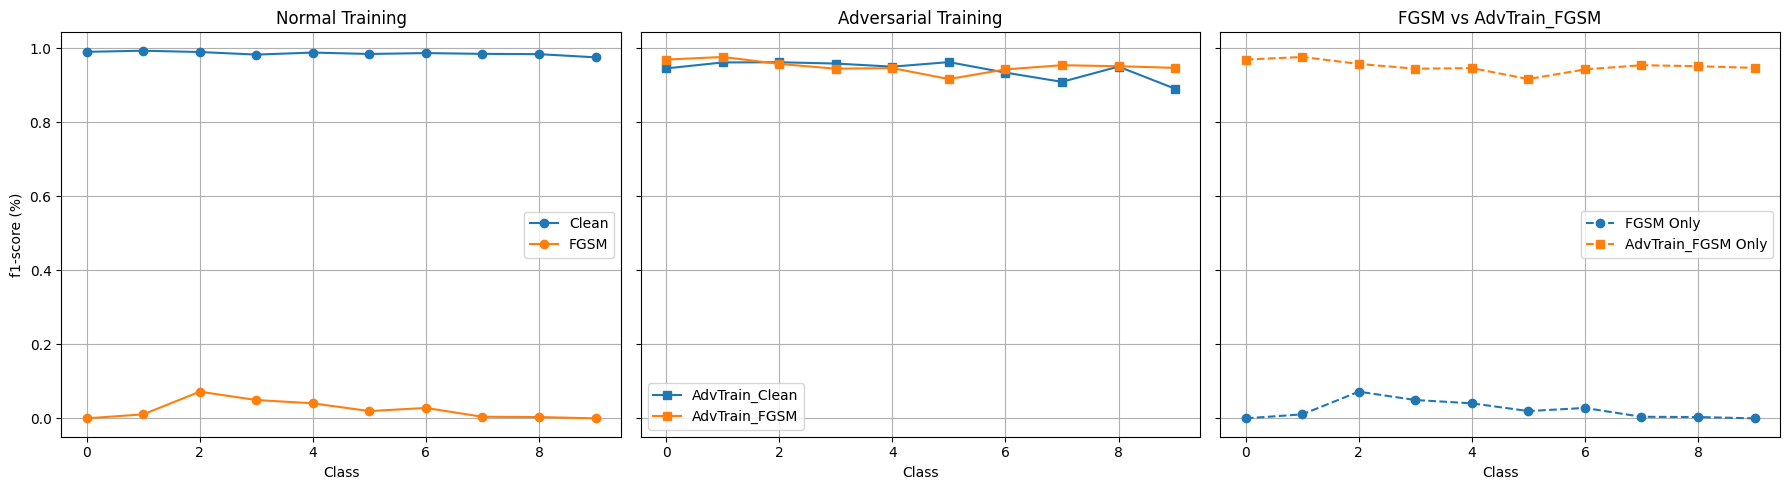

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to your CSV file
CSV_PATH = 'Classification_Report_Comparison.csv'

# Load the CSV
df = pd.read_csv(CSV_PATH)

# Drop PGD-related scenarios
df = df[~df['Scenario'].isin(['PGD', 'AdvTrain_PGD'])]

# Choose the column to plot as 'accuracy'.
# If your file has an 'Accuracy' column, it will be used; otherwise it falls back to 'f1-score'
accuracy_col = 'Accuracy' if 'Accuracy' in df.columns else 'f1-score'

# Pivot so that each Scenario becomes a column, indexed by Class
pivot = df.pivot(index='Class', columns='Scenario', values=accuracy_col)

# Extract classes (x-axis)
classes = pivot.index

# Create a figure with 3 side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot 1: Normal training (Clean, FGSM)
axes[0].plot(classes, pivot['Clean'], marker='o', label='Clean')
axes[0].plot(classes, pivot['FGSM'], marker='o', label='FGSM')
axes[0].set_title('Normal Training')
axes[0].set_xlabel('Class')
axes[0].set_ylabel(f'{accuracy_col} (%)')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Adversarial training (AdvTrain_Clean, AdvTrain_FGSM)
axes[1].plot(classes, pivot['AdvTrain_Clean'], marker='s', label='AdvTrain_Clean')
axes[1].plot(classes, pivot['AdvTrain_FGSM'], marker='s', label='AdvTrain_FGSM')
axes[1].set_title('Adversarial Training')
axes[1].set_xlabel('Class')
axes[1].legend()
axes[1].grid(True)

# Plot 3: FGSM vs AdvTrain_FGSM only
axes[2].plot(classes, pivot['FGSM'], linestyle='--', marker='o', label='FGSM Only')
axes[2].plot(classes, pivot['AdvTrain_FGSM'], linestyle='--', marker='s', label='AdvTrain_FGSM Only')
axes[2].set_title('FGSM vs AdvTrain_FGSM')
axes[2].set_xlabel('Class')
axes[2].legend()
axes[2].grid(True)

# Improve layout and show
plt.tight_layout()
plt.show()


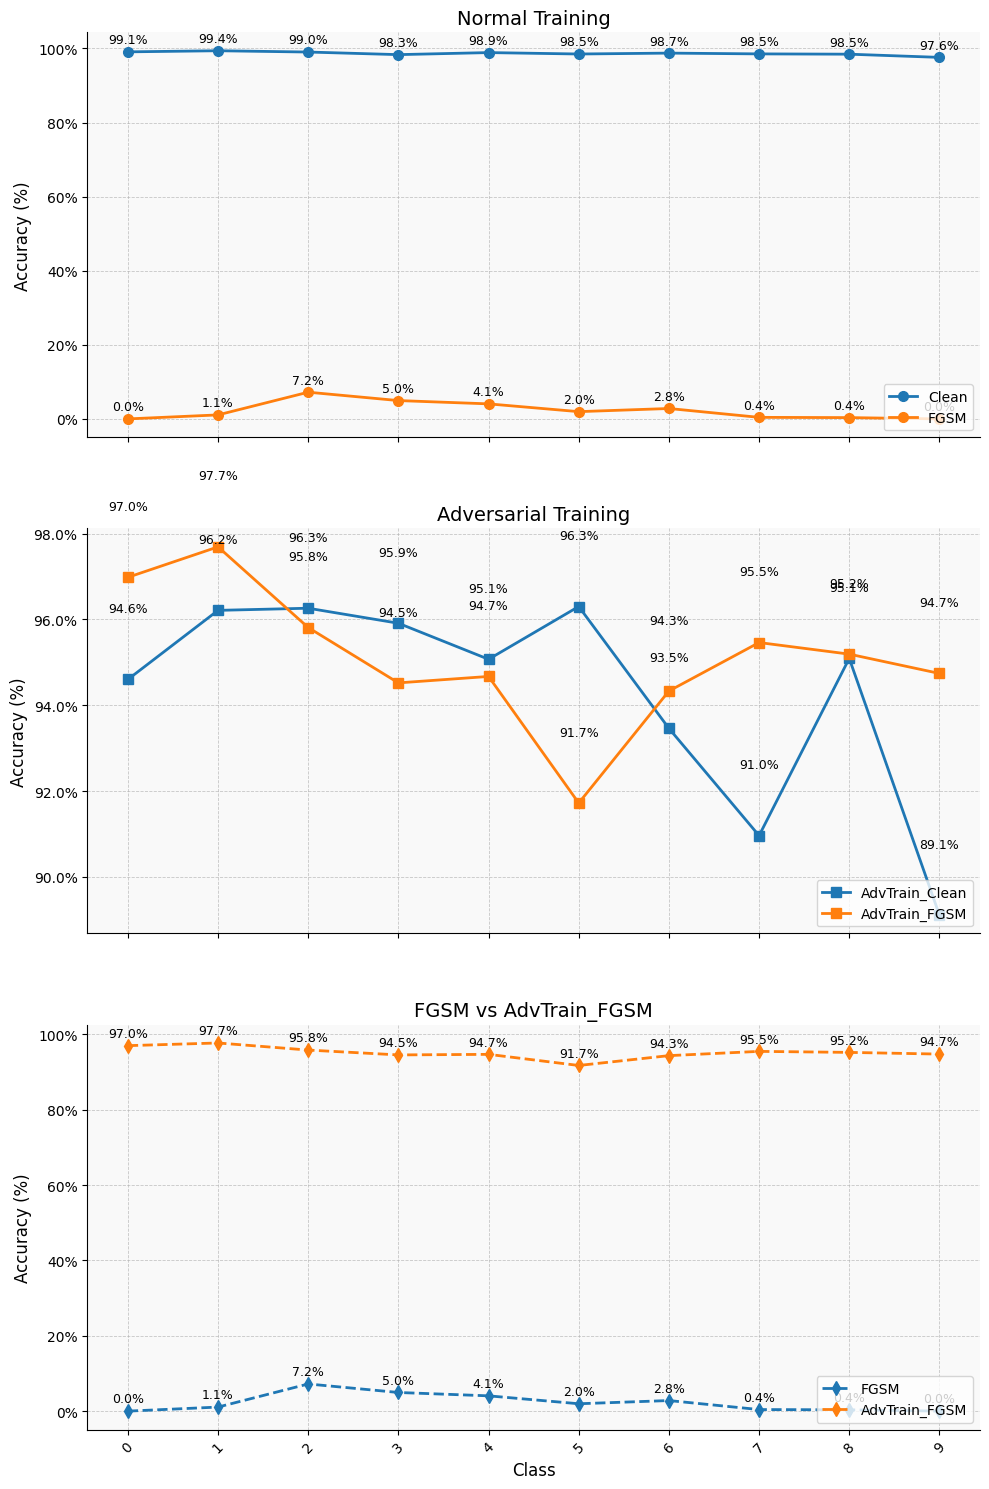

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# ---- Configuration ----
CSV_PATH = 'Classification_Report_Comparison.csv'  # update to your CSV path
PGD_SCENARIOS = ['PGD', 'AdvTrain_PGD']
# -----------------------

# Load & filter
df = pd.read_csv(CSV_PATH)
df = df[~df['Scenario'].isin(PGD_SCENARIOS)]

# Choose metric column (falls back to f1-score if no Accuracy column)
accuracy_col = 'Accuracy' if 'Accuracy' in df.columns else 'f1-score'

# Pivot so each scenario is a column, indexed by Class
pivot = df.pivot(index='Class', columns='Scenario', values=accuracy_col)

# Convert to percent
pivot_perc = pivot * 100
classes = pivot_perc.index

# Set up 3 vertical subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
# fig.suptitle('Class-wise Accuracy Comparison (PGD Rows Excluded)', fontsize=18, y=0.94)

# Common styling
for ax in axes:
    ax.set_facecolor('#f9f9f9')
    ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(classes)
    ax.set_xticklabels(classes, rotation=45)
    ax.yaxis.set_major_formatter(PercentFormatter())

# Plot configurations: (scenarios, title, marker styles, line styles)
plot_configs = [
    (['Clean', 'FGSM'],             'Normal Training',       ['o','o'], ['-','-']),
    (['AdvTrain_Clean', 'AdvTrain_FGSM'], 'Adversarial Training', ['s','s'], ['-','-']),
    (['FGSM', 'AdvTrain_FGSM'],      'FGSM vs AdvTrain_FGSM', ['d','d'], ['--','--']),
]

# Plot & annotate
for ax, (scenarios, title, markers, linestyles) in zip(axes, plot_configs):
    for scen, m, ls in zip(scenarios, markers, linestyles):
        y = pivot_perc[scen]
        ax.plot(classes, y, marker=m, linestyle=ls, linewidth=2, markersize=7, label=scen)
        # annotate each point
        for x, val in zip(classes, y):
            ax.text(x, val + 1.5, f"{val:.1f}%", ha='center', va='bottom', fontsize=9)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.legend(loc='lower right', fontsize=10)

# X-axis label only on the bottom plot
axes[-1].set_xlabel('Class', fontsize=12)

plt.tight_layout(h_pad=2.5)
plt.show()
